<a href="https://colab.research.google.com/github/Maria-Rumki/NLP-Assignments/blob/main/%2019%20Jan%20-%20GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment
Constraint: Only use our code (not other code....)

1. I guess you already try a bigger corpus
2. I guess you already try window size 2
3. I guess you already have skipgram, skipgram(neg), cbow, glove

Do this:

1. Compare them based on syntactic accuracy and semantic accuracy, similar to how is done in https://nlp.stanford.edu/pubs/glove.pdf (see Table 2) - NO NEED to try 1000 or 300 embed size.....I just want you to learn how to do experiment.....
2. Try to find a correlation with just ONE similarity dataset (which humans judge how similar is two words.....)

Point criteria: 

0: Not done 

1: ok 

2: with comments / explanation / figures just like how Chaky explain thing.....

In [511]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [512]:
np.__version__, torch.__version__

('1.22.4', '1.13.1+cu116')

In [513]:
import matplotlib
matplotlib.__version__

'3.5.3'

Loading Data


In [514]:
# defining corpus

with open('capital-world.txt') as txt:
    corpus = [line.strip() for line in txt.readlines() if line[0] != ':']


In [515]:
print(corpus[:10])

['abuja nigeria accra ghana', 'abuja nigeria algiers algeria', 'abuja nigeria amman jordan', 'abuja nigeria ankara turkey', 'abuja nigeria antananarivo madagascar', 'abuja nigeria apia samoa', 'abuja nigeria ashgabat turkmenistan', 'abuja nigeria asmara eritrea', 'abuja nigeria astana kazakhstan', 'abuja nigeria athens greece']


In [516]:
# tokenization

corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized[:15]  # we called each of this as "tokens", NOT words

[['abuja', 'nigeria', 'accra', 'ghana'],
 ['abuja', 'nigeria', 'algiers', 'algeria'],
 ['abuja', 'nigeria', 'amman', 'jordan'],
 ['abuja', 'nigeria', 'ankara', 'turkey'],
 ['abuja', 'nigeria', 'antananarivo', 'madagascar'],
 ['abuja', 'nigeria', 'apia', 'samoa'],
 ['abuja', 'nigeria', 'ashgabat', 'turkmenistan'],
 ['abuja', 'nigeria', 'asmara', 'eritrea'],
 ['abuja', 'nigeria', 'astana', 'kazakhstan'],
 ['abuja', 'nigeria', 'athens', 'greece'],
 ['abuja', 'nigeria', 'baghdad', 'iraq'],
 ['abuja', 'nigeria', 'baku', 'azerbaijan'],
 ['abuja', 'nigeria', 'bamako', 'mali'],
 ['abuja', 'nigeria', 'bangkok', 'thailand'],
 ['abuja', 'nigeria', 'banjul', 'gambia']]

In [517]:
# numericalization

# getting all the unique words
# we want to flatten this (basically merge all list)

flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  # vocabs is a term defining all unique words your system know

In [518]:
vocabs[:15]

['santiago',
 'china',
 'kazakhstan',
 'indonesia',
 'botswana',
 'kigali',
 'tashkent',
 'belgium',
 'slovakia',
 'uzbekistan',
 'lebanon',
 'burundi',
 'harare',
 'thimphu',
 'honduras']

In [519]:

# checking the length of the vocab

len(vocabs)

232

In [520]:
# assigning id to all these vocabs

word2index = {v: idx for idx, v in enumerate(vocabs)}

In [521]:
word2index['china']

1

In [522]:
# adding , which is a very normal token exists in the world

vocabs.append('')

In [523]:
# now we have a way to know what is the id of 

word2index[''] = 232

In [524]:
# creating index2word dictionary
   
index2word = {v:k for k, v in word2index.items()}
index2word[2]

'kazakhstan'

In [525]:
vocabs[:15]

['santiago',
 'china',
 'kazakhstan',
 'indonesia',
 'botswana',
 'kigali',
 'tashkent',
 'belgium',
 'slovakia',
 'uzbekistan',
 'lebanon',
 'burundi',
 'harare',
 'thimphu',
 'honduras']

**Skipgram**

In [526]:
# moving along the corpus
# using window_size = 1

skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    for i in range(1, len(sent) - 1): # start from 1 to second last
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  # window_size = 1
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:15]
        
# here we want to create ('wrenley', 'raya'), ('wrenley', 'angelique') append to some list

[['nigeria', 'abuja'],
 ['nigeria', 'accra'],
 ['accra', 'nigeria'],
 ['accra', 'ghana'],
 ['nigeria', 'abuja'],
 ['nigeria', 'algiers'],
 ['algiers', 'nigeria'],
 ['algiers', 'algeria'],
 ['nigeria', 'abuja'],
 ['nigeria', 'amman'],
 ['amman', 'nigeria'],
 ['amman', 'jordan'],
 ['nigeria', 'abuja'],
 ['nigeria', 'ankara'],
 ['ankara', 'nigeria']]

In [527]:
def random_batch(batch_size, corpus):
    
    skipgrams = []

    # for each corpus
    for sent in corpus_tokenized:
        # for each sent ["Athens", "Greece", "Baghdad", "Iraq"]
        for i in range(1, len(sent) - 1): # start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  # window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    # only getting a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    # appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  # center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
     

In [528]:
random_batch(10, corpus_tokenized)

(array([[ 35],
        [ 95],
        [133],
        [149],
        [154],
        [ 60],
        [ 16],
        [ 33],
        [ 50],
        [188]]), array([[ 20],
        [166],
        [ 15],
        [196],
        [ 19],
        [192],
        [  0],
        [123],
        [225],
        [226]]))

Testing the Method


In [529]:
input, label = random_batch(2, corpus_tokenized)

print(f"{input=}")
print(f"{label=}")

input=array([[186],
       [  6]])
label=array([[10],
       [ 9]])


In [530]:
input, label = random_batch(1, corpus_tokenized)

print(f"{input=}")
print(f"{label=}")

input=array([[30]])
label=array([[214]])


In [531]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[144],
       [228],
       [ 56],
       [128],
       [ 21],
       [137],
       [200],
       [133],
       [207],
       [149]])


Modeling

In [532]:
voc_size = len(vocabs)
voc_size

233

In [533]:
vocabs[:15]

['santiago',
 'china',
 'kazakhstan',
 'indonesia',
 'botswana',
 'kigali',
 'tashkent',
 'belgium',
 'slovakia',
 'uzbekistan',
 'lebanon',
 'burundi',
 'harare',
 'thimphu',
 'honduras']

In [534]:
# the model will accept three vectors - u_o, v_c, u_w
# u_o - vector for outside words
# v_c - vector for center word
# u_w - vectors of all vocabs

class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  # it is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
      
        # center_word, outside_word: (batch_size, 1)
        # all_vocabs: (batch_size, voc_size)
        
        # converting them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     # (batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   # (batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     # (batch_size, voc_size, emb_size)
        
        # bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        # (batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  # exp(uo vc)
        # (batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         # (batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        # (batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        # (batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [535]:
# preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    # map(function, list of something)
    # map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index[""], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 233])

In [536]:
voc_size

233

In [537]:
input, label = random_batch(2, corpus_tokenized)
input # center word

array([[18],
       [47]])

In [538]:
label # context word

array([[60],
       [46]])

In [539]:
voc_size

233

In [540]:
emb_size = 2 # usually, this can be 50, 100, or 300
model = Skipgram(voc_size, emb_size)

In [541]:
input_tensor = torch.LongTensor(input)
label_tensor = torch.LongTensor(label)  #LongTensor basically means integer....

In [542]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [543]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [544]:

loss

tensor(6.1730, grad_fn=<NegBackward0>)

Training

In [545]:
batch_size = 2
emb_size = 2
model_skipgram = Skipgram(voc_size, emb_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_skipgram.parameters(), lr = 0.001)
     

In [546]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [547]:
import time

init_time = time.time()

# training
num_epochs = 500
for epoch in range(num_epochs):
    
    start_time = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  
    target_batch = torch.LongTensor(target_batch) 
    # print(input_batch.shape)
    # print(target_batch.shape)

    optimizer.zero_grad()

    # loss = model
    loss = model(input_batch, target_batch, all_vocabs)
    
    # backpropagation
    loss.backward()

    # updating alpha
    optimizer.step()
    
    epoch_time = time.time() - start_time

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_time}") # printing epoch loss

total_time = time.time() - init_time
print('Total training time:', total_time)

Epoch: 100 | cost: 7.248770 | time: 0.01677083969116211
Epoch: 200 | cost: 8.456260 | time: 0.009541988372802734
Epoch: 300 | cost: 4.821965 | time: 0.00957036018371582
Epoch: 400 | cost: 6.851594 | time: 0.07851076126098633
Epoch: 500 | cost: 6.647005 | time: 0.029672622680664062
Total training time: 13.081906080245972


Plotting the Embeddings


In [548]:
vocabs[:15]

['santiago',
 'china',
 'kazakhstan',
 'indonesia',
 'botswana',
 'kigali',
 'tashkent',
 'belgium',
 'slovakia',
 'uzbekistan',
 'lebanon',
 'burundi',
 'harare',
 'thimphu',
 'honduras']

In [549]:
kazakhstan = torch.LongTensor([word2index['kazakhstan']])
kazakhstan
     

tensor([2])

In [550]:
kazakhstan_center_embed = model.embedding_center_word(kazakhstan)
kazakhstan_outisde_embed = model.embedding_outside_word(kazakhstan)

kazakhstan_embed = (kazakhstan_center_embed + kazakhstan_outisde_embed) / 2
kazakhstan_embed

tensor([[0.1623, 0.4983]], grad_fn=<DivBackward0>)

In [551]:
def get_embed(word):
  
    try:
        index = word2index[word]
    except:
        index = word2index['']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [552]:

# finding embedding of turkey, romania

print(get_embed('turkey'))
print(get_embed('romania'))

(-1.370731234550476, -0.21434199810028076)
(-0.1090434342622757, -0.8933303952217102)


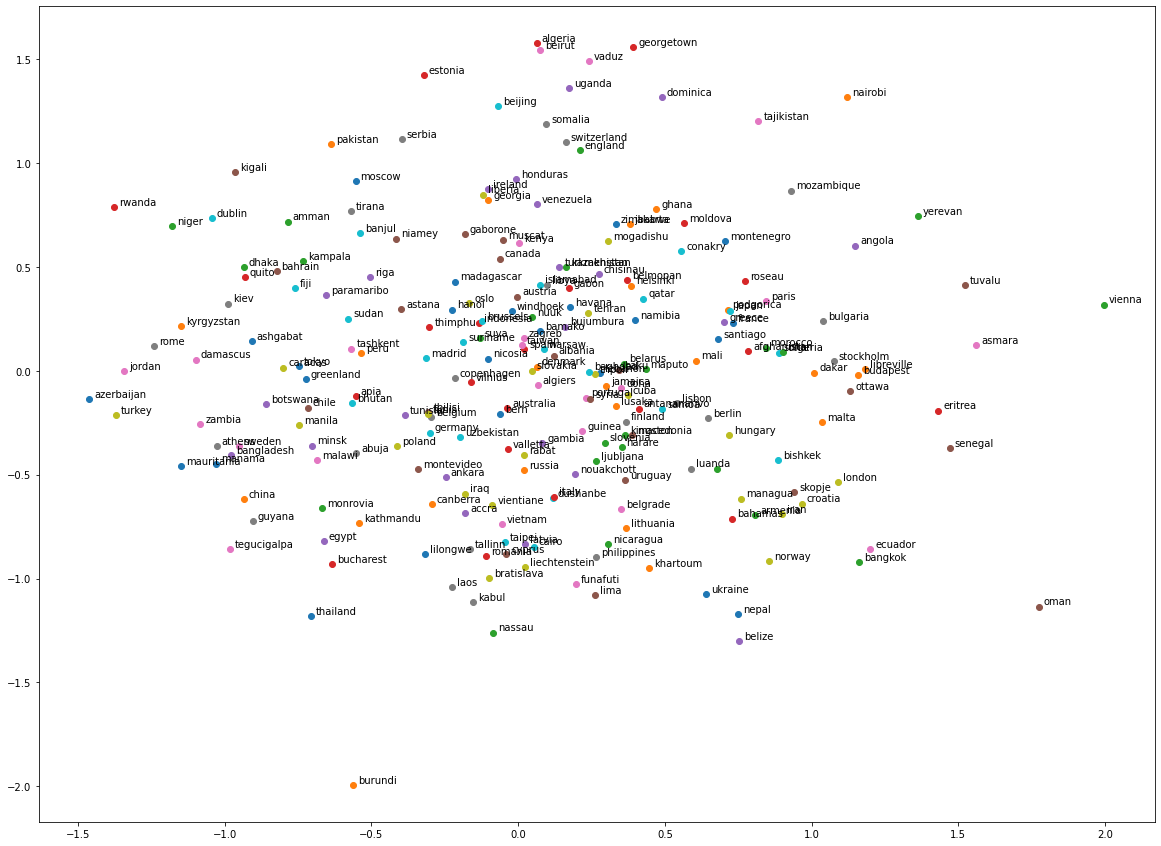

In [553]:
# plotting the words 

plt.figure(figsize=(20,15))
for i, word in enumerate(vocabs): # looping each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

Continuous Bag-of-Words (CBOW)

In [554]:
vocabs[:20]

['santiago',
 'china',
 'kazakhstan',
 'indonesia',
 'botswana',
 'kigali',
 'tashkent',
 'belgium',
 'slovakia',
 'uzbekistan',
 'lebanon',
 'burundi',
 'harare',
 'thimphu',
 'honduras',
 'astana',
 'ecuador',
 'somalia',
 'caracas',
 'banjul']

In [555]:
# vocab size
voc_size = len(vocabs)
print(voc_size)

233


Preparing Train Data

In [556]:
for c in corpus[:15]:
    print(c)

abuja nigeria accra ghana
abuja nigeria algiers algeria
abuja nigeria amman jordan
abuja nigeria ankara turkey
abuja nigeria antananarivo madagascar
abuja nigeria apia samoa
abuja nigeria ashgabat turkmenistan
abuja nigeria asmara eritrea
abuja nigeria astana kazakhstan
abuja nigeria athens greece
abuja nigeria baghdad iraq
abuja nigeria baku azerbaijan
abuja nigeria bamako mali
abuja nigeria bangkok thailand
abuja nigeria banjul gambia


In [557]:
cbows = []

# for each corpus
window_size = 1
for sent in corpus_tokenized:
    for i in range(window_size, len(sent) - window_size): 
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
        # center_word = sent[i]
        cbows.append([outside_words, center_word])

cbows[:15]

[[['abuja', 'accra'], 'nigeria'],
 [['nigeria', 'ghana'], 'accra'],
 [['abuja', 'algiers'], 'nigeria'],
 [['nigeria', 'algeria'], 'algiers'],
 [['abuja', 'amman'], 'nigeria'],
 [['nigeria', 'jordan'], 'amman'],
 [['abuja', 'ankara'], 'nigeria'],
 [['nigeria', 'turkey'], 'ankara'],
 [['abuja', 'antananarivo'], 'nigeria'],
 [['nigeria', 'madagascar'], 'antananarivo'],
 [['abuja', 'apia'], 'nigeria'],
 [['nigeria', 'samoa'], 'apia'],
 [['abuja', 'ashgabat'], 'nigeria'],
 [['nigeria', 'turkmenistan'], 'ashgabat'],
 [['abuja', 'asmara'], 'nigeria']]


Modeling



In [558]:
def make_context_vector(outside_words, word2index):
    idxs = [word2index[w] for w in outside_words]
    return torch.tensor(idxs, dtype=torch.long)
     

In [559]:
class CBOW(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super(CBOW, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)
        self.act_func = nn.LogSoftmax(dim = -1)
        
    def forward(self, inputs):
        embeds = sum(self.embedding(inputs)).view(1,-1)
        out = self.linear(embeds)
        out = self.act_func(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word2index[word]])
        return self.embedding(word).view(1,-1)

Training

In [560]:
embedding_size = 2
model_cbow = CBOW(voc_size, embedding_size)
     

In [561]:
model_cbow

CBOW(
  (embedding): Embedding(233, 2)
  (linear): Linear(in_features=2, out_features=233, bias=True)
  (act_func): LogSoftmax(dim=-1)
)

In [562]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=0.001)

In [563]:
init_time = time.time()

# training
num_epochs = 500

for epoch in range(num_epochs):

    start_time = time.time()
    loss = 0

    for context, target in cbows:
        context_vector = make_context_vector(context, word2index)
        log_probs = model_cbow(context_vector)
        loss += loss_function(log_probs, torch.tensor([word2index[target]]))

    # optimizing at the end of each epoch
    optimizer.zero_grad()

    loss.backward()
    optimizer.step()

    epoch_time = time.time() - start_time
    
    # print(f"epoch: {epoch}, loss: {loss}")
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_time}")

total_time = time.time() - init_time
print('Total training time:', total_time)

Epoch: 100 | cost: 41693.703125 | time: 2.4229023456573486
Epoch: 200 | cost: 35296.523438 | time: 1.8703293800354004
Epoch: 300 | cost: 32512.429688 | time: 2.039612293243408
Epoch: 400 | cost: 31109.097656 | time: 1.8939108848571777
Epoch: 500 | cost: 30335.839844 | time: 1.9095120429992676
Total training time: 1041.2320637702942


Skipgram Negative Sampling


Unigram Distribution

In [564]:
Z = 0.001

from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
num_total_words = sum([c for w, c in word_count.items()])

In [565]:
num_total_words 

18096

In [566]:
unigram_table = []

for vo in vocabs:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [567]:
print(len(vocabs), len(unigram_table))

233 3712


In [568]:
# Counter(unigram_table)

Negative Sampling

In [569]:
import random

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index[""], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    
    return torch.cat(neg_samples)

Testing

In [570]:
input_batch, label_batch = random_batch(batch_size, skipgrams)
input_batch  = torch.Tensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [571]:
label_batch.shape

torch.Size([2, 1])

In [572]:
num_neg = 3
negative_sampling(label_batch, unigram_table, num_neg)

tensor([[142,  67, 118],
        [ 80, 167, 100]])

Modeling

In [573]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_center_word  = nn.Embedding(vocab_size, emb_size)  # center embedding
        self.embedding_outside_word = nn.Embedding(vocab_size, emb_size)  # outside embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, outside_words, negative_words):
        center_word_embed  = self.embedding_center_word(center_words)     # (batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_words)   # (batch_size, 1, emb_size)
        # all_vocabs_embed   = self.embedding_outside_word(all_vocabs)
        neg_embeds    = -self.embedding_outside_word(negative_words)  # [batch_size, num_neg, emb_size]
        
        positive_score = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        # [batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        negative_score = neg_embeds.bmm(center_word_embed.transpose(1, 2))
        # [batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        return embeds

Training

In [574]:
len(vocabs)

233

In [575]:
batch_size = 2 # mini-batch size
embedding_size = 2 # so we can later plot
model_negskip = SkipgramNegSampling(len(vocabs), embedding_size)
num_neg = 10 # num of negative sampling

optimizer = optim.Adam(model_negskip.parameters(), lr=0.001)

In [576]:
model_negskip

SkipgramNegSampling(
  (embedding_center_word): Embedding(233, 2)
  (embedding_outside_word): Embedding(233, 2)
  (logsigmoid): LogSigmoid()
)

In [577]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [578]:
import time

init_time = time.time()

# Training
num_epochs = 500
for epoch in range(num_epochs):
    
    start_time = time.time()
    
    input_batch, target_batch = random_batch(batch_size, corpus)
    
    # input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    
    # target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    
    # negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(label_batch, unigram_table, 3)
    
    optimizer.zero_grad()
    loss = model_negskip(input_batch, target_batch, negs_batch)
    
    loss.backward()
    optimizer.step()

    epoch_time = time.time() - start_time

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_time}")

total_time = time.time() - init_time
print('Total training time:', total_time)
     

Epoch: 100 | cost: 5.162031 | time: 0.10823178291320801
Epoch: 200 | cost: 4.075013 | time: 0.01031184196472168
Epoch: 300 | cost: 2.940463 | time: 0.010599613189697266
Epoch: 400 | cost: 3.561136 | time: 0.00911259651184082
Epoch: 500 | cost: 2.968183 | time: 0.009778499603271484
Total training time: 12.446539878845215


GloVe

Co-occurrence matrix

In [579]:
# using Counter to first count stuffs
from collections import Counter

# counting the frequency of each word....
# we somehow need this to calculate the probability Pi
X_i = Counter(flatten(corpus_tokenized)) # merging all list....(flatten is a function I define.....)

# X_i['apple'] #get the probability of apple
     

In [580]:
corpus_tokenized[:15]
     

[['abuja', 'nigeria', 'accra', 'ghana'],
 ['abuja', 'nigeria', 'algiers', 'algeria'],
 ['abuja', 'nigeria', 'amman', 'jordan'],
 ['abuja', 'nigeria', 'ankara', 'turkey'],
 ['abuja', 'nigeria', 'antananarivo', 'madagascar'],
 ['abuja', 'nigeria', 'apia', 'samoa'],
 ['abuja', 'nigeria', 'ashgabat', 'turkmenistan'],
 ['abuja', 'nigeria', 'asmara', 'eritrea'],
 ['abuja', 'nigeria', 'astana', 'kazakhstan'],
 ['abuja', 'nigeria', 'athens', 'greece'],
 ['abuja', 'nigeria', 'baghdad', 'iraq'],
 ['abuja', 'nigeria', 'baku', 'azerbaijan'],
 ['abuja', 'nigeria', 'bamako', 'mali'],
 ['abuja', 'nigeria', 'bangkok', 'thailand'],
 ['abuja', 'nigeria', 'banjul', 'gambia']]

In [581]:
# defining a skipgram of window size 1
skip_grams = []

# looping through each corpus
for sent in corpus_tokenized:  #['apple', 'banana', 'fruit']
    # looping through each word from 1 to n-1 (because 0 and n has no context window)
    for i in range(1, len(sent)-1):
        target  = sent[i]
        context = [sent[i+1], sent[i-1]]
        # appending(i, i+1) and (i, i-1)
        for c in context:
            skip_grams.append((target, c))

In [582]:
corpus_tokenized[:15]

[['abuja', 'nigeria', 'accra', 'ghana'],
 ['abuja', 'nigeria', 'algiers', 'algeria'],
 ['abuja', 'nigeria', 'amman', 'jordan'],
 ['abuja', 'nigeria', 'ankara', 'turkey'],
 ['abuja', 'nigeria', 'antananarivo', 'madagascar'],
 ['abuja', 'nigeria', 'apia', 'samoa'],
 ['abuja', 'nigeria', 'ashgabat', 'turkmenistan'],
 ['abuja', 'nigeria', 'asmara', 'eritrea'],
 ['abuja', 'nigeria', 'astana', 'kazakhstan'],
 ['abuja', 'nigeria', 'athens', 'greece'],
 ['abuja', 'nigeria', 'baghdad', 'iraq'],
 ['abuja', 'nigeria', 'baku', 'azerbaijan'],
 ['abuja', 'nigeria', 'bamako', 'mali'],
 ['abuja', 'nigeria', 'bangkok', 'thailand'],
 ['abuja', 'nigeria', 'banjul', 'gambia']]

In [583]:
skip_grams[:15]

[('nigeria', 'accra'),
 ('nigeria', 'abuja'),
 ('accra', 'ghana'),
 ('accra', 'nigeria'),
 ('nigeria', 'algiers'),
 ('nigeria', 'abuja'),
 ('algiers', 'algeria'),
 ('algiers', 'nigeria'),
 ('nigeria', 'amman'),
 ('nigeria', 'abuja'),
 ('amman', 'jordan'),
 ('amman', 'nigeria'),
 ('nigeria', 'ankara'),
 ('nigeria', 'abuja'),
 ('ankara', 'turkey')]

In [584]:
# since we have these occurrences, we can count, to make our co-occurrence matrix!!!
X_ik_skipgram = Counter(skip_grams)
# X_ik_skipgram

In [603]:
X_ik_skipgram[('algiers', 'algeria')]

39

In [604]:
X_ik_skipgram[('ankara', 'turkey')]

39

Weighting Function f

In [605]:
def weighting(w_i, w_j, X_ik):   # we need w_i and w_j, because we can try its co-occurrences, if it's too big, we scale it down
    
    # checking whether the co-occurrences between these two word exists???
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  # why one, so that the probability thingy won't break...(label smoothing)
        
    # maximum co-occurrences; we follow the paper
    x_max = 100
    alpha = 0.75
    
    # if the co-occurrences does not exceed x_max, scale it down based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max) ** alpha
    else:
        result = 1 # this is the maximum probability we can have
        
    return result

In [606]:
w_i  = 'turkey'
w_j  = 'ankara'
w_j2 = 'bangkok'

print(weighting(w_i, w_j, X_ik_skipgram))   # scales from 1 to 0.0316
print(weighting(w_i, w_j2, X_ik_skipgram))  # the paper says that f(0) = 0
     

0.4935128386754873
0.03162277660168379


In [607]:
vocabs[:15]

['santiago',
 'china',
 'kazakhstan',
 'indonesia',
 'botswana',
 'kigali',
 'tashkent',
 'belgium',
 'slovakia',
 'uzbekistan',
 'lebanon',
 'burundi',
 'harare',
 'thimphu',
 'honduras']

In [608]:
# applying this weighting to all possible pairs
from itertools import combinations_with_replacement

X_ik = {} # for keeping the co-occurrences
weighting_dic = {} # for keeping all the probability after passing through the weighting function

for bigram in combinations_with_replacement(vocabs, 2):  # we need to also think its reverse
    # if this bigram exists in X_ik_skipgrams
    # we gonna add this to our co-occurence matrix
    if X_ik_skipgram.get(bigram) is not None:
        cooc = X_ik_skipgram[bigram]  # getting the co-occurrence
        X_ik[bigram] = cooc + 1 # this is again basically label smoothing....(stability issues (especially when divide something))
        X_ik[(bigram[1], bigram[0])] = cooc + 1  # trick to get all pairs
    else: # otherwise, do nothing
        pass
    
    # applying the weighting function using this co-occurrence matrix thingy    
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)
     

In [609]:
len(X_ik_skipgram)

9280

Preparing Train Data

In [610]:
for c in corpus_tokenized[:10]:
    print(c)

['abuja', 'nigeria', 'accra', 'ghana']
['abuja', 'nigeria', 'algiers', 'algeria']
['abuja', 'nigeria', 'amman', 'jordan']
['abuja', 'nigeria', 'ankara', 'turkey']
['abuja', 'nigeria', 'antananarivo', 'madagascar']
['abuja', 'nigeria', 'apia', 'samoa']
['abuja', 'nigeria', 'ashgabat', 'turkmenistan']
['abuja', 'nigeria', 'asmara', 'eritrea']
['abuja', 'nigeria', 'astana', 'kazakhstan']
['abuja', 'nigeria', 'athens', 'greece']


In [611]:

skip_grams[:10]

[('nigeria', 'accra'),
 ('nigeria', 'abuja'),
 ('accra', 'ghana'),
 ('accra', 'nigeria'),
 ('nigeria', 'algiers'),
 ('nigeria', 'abuja'),
 ('algiers', 'algeria'),
 ('algiers', 'nigeria'),
 ('nigeria', 'amman'),
 ('nigeria', 'abuja')]

In [612]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    # looping through this skipgram, and changing it to id  because when sending model, it must have a number
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    # randomly picking "batch_size" indexes
    number_of_choices = len(skip_grams_id)
    random_index = np.random.choice(number_of_choices, batch_size, replace=False) # no repeating indexes among these random indexes
    
    random_inputs = [] #xi, wi (in batches)
    random_labels = [] #xj, wj (in batches)
    random_coocs  = [] #Xij (in batches)
    random_weighting = [] #f(Xij) (in batches)
    # for each of the sample in these indexes
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]]) # same reason why i put bracket here....
        random_labels.append([skip_grams_id[i][1]])
        
        # getting cooc
        # first checking whether it exists...
        pair = skip_grams[i]  #e.g., ('banana', 'fruit)
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1 #label smoothing
            
        random_coocs.append([math.log(cooc)])  # 1. why log, # 2. why bracket -> size ==> (, 1)  # my neural network expects (, 1)
        
        # getting weighting
        weighting = weighting_dic[pair]  # why not use try....maybe it does not exist....
        random_weighting.append(weighting)

        
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weighting)
    

In [613]:
batch_size = 2
input, target, cooc, weightin = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
   

In [596]:
input, target, cooc, weightin

(array([[111],
        [134]]), array([[134],
        [ 62]]), array([[0.69314718],
        [3.68887945]]), array([0.05318296, 0.50297337]))

Modeling

In [614]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

Training

In [615]:
voc_size = len(vocabs)
batch_size = 2 # why?  no reason; 
emb_size = 2 # why?  no reason; usually 50, 100, 300, but 2 so we can plot (we can also plot 50, but we need to do PCA)
model_glove = GloVe(voc_size, emb_size)

optimizer = optim.Adam(model_glove.parameters(), lr=0.001)

In [616]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [617]:
init_time = time.time()

# training
num_epochs = 500

# for epoch
for epoch in range(num_epochs):

    start_time = time.time()

    # getting random batch
    input, target, cooc, weightin = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
    input_batch = torch.LongTensor(input)
    target_batch = torch.LongTensor(target)
    cooc_batch = torch.FloatTensor(cooc)
    weightin_batch = torch.FloatTensor(weightin)
       
    # print(input_batch.shape, label_batch.shape, cooc_batch.shape, weightin_batch)
    
    # loss = model
    loss = model_glove(input_batch, target_batch, cooc_batch, weightin_batch)
    
    # backpropagation
    loss.backward()
    
    # updating alpha
    optimizer.step()
    
    epoch_time = time.time() - start_time

    # printing epoch loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_time}")

total_time = time.time() - init_time
print('Total training time:', total_time)

Epoch: 100 | cost: 10.693885 | time: 0.005293130874633789
Epoch: 200 | cost: 45.966034 | time: 0.00485682487487793
Epoch: 300 | cost: 6.304430 | time: 0.004884958267211914
Epoch: 400 | cost: 1.936267 | time: 0.008531570434570312
Epoch: 500 | cost: 0.117152 | time: 0.008860588073730469
Total training time: 3.483180046081543


Plot the Embeddings

In [618]:
vocabs[:10]

['santiago',
 'china',
 'kazakhstan',
 'indonesia',
 'botswana',
 'kigali',
 'tashkent',
 'belgium',
 'slovakia',
 'uzbekistan']

In [619]:
kazakhstan = torch.LongTensor([word2index['kazakhstan']])
kazakhstan

tensor([2])

In [620]:
kazakhstan_center_embed = model_glove.embedding_v(kazakhstan)
kazakhstan_outisde_embed = model_glove.embedding_u(kazakhstan)

kazakhstan_embed = (kazakhstan_center_embed + kazakhstan_outisde_embed) / 2
kazakhstan_embed

tensor([[-0.0816,  0.3906]], grad_fn=<DivBackward0>)

In [621]:
def get_embed(word):
  
    try:
        index = word2index[word]
    except:
        index = word2index['']
    
    word = torch.LongTensor([index])

    center_embed  = model_glove.embedding_v(word)
    outside_embed = model_glove.embedding_u(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

In [622]:
# finding embedding of greece, jordan

print(get_embed('greece'))
print(get_embed('jordan'))

(0.25350549817085266, 0.7509941458702087)
(0.3426963686943054, 0.5169715285301208)


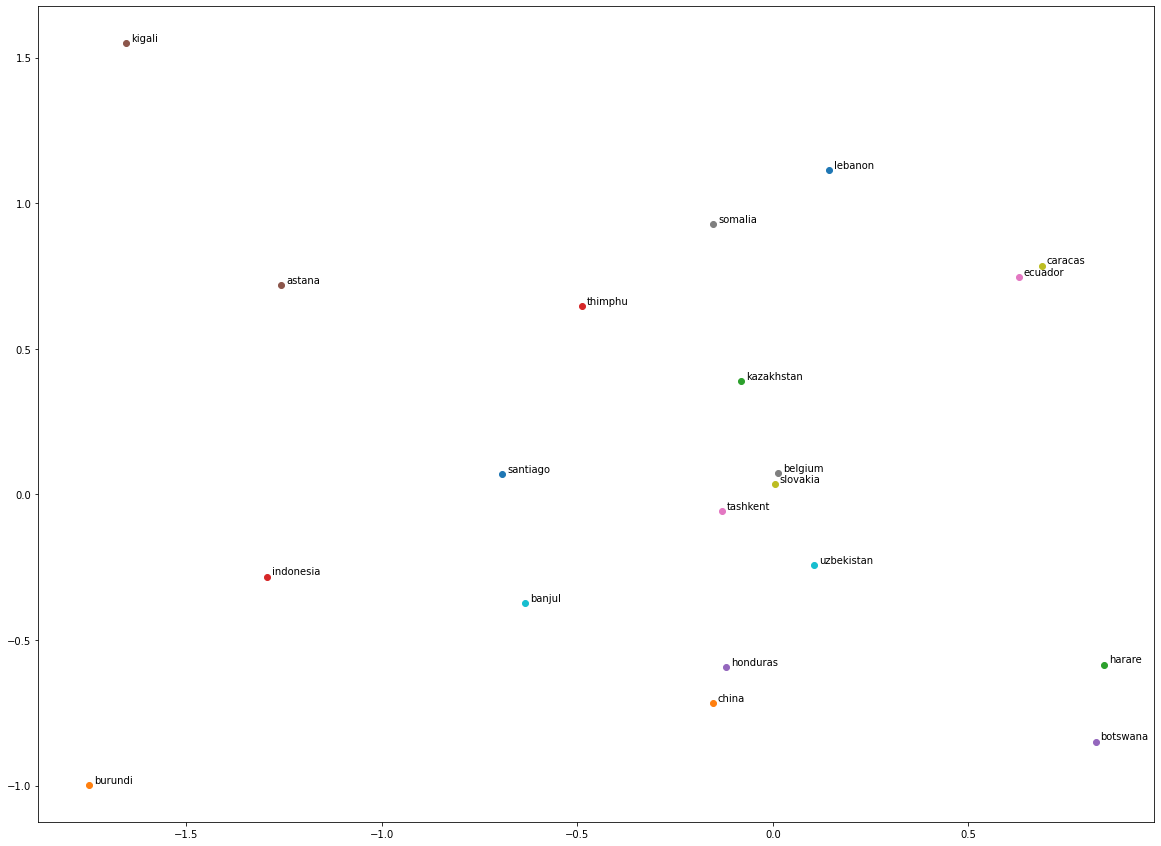

In [623]:
# plotting the words

plt.figure(figsize=(20,15))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()
     

Loading Test Dataset

In [624]:
with open('questions-words.txt') as file:
    test_data = [line.strip() for line in file.readlines() if line[0] != ':']
     

In [625]:
len(test_data)

19544

In [626]:
test_data[:10]

['Athens Greece Baghdad Iraq',
 'Athens Greece Bangkok Thailand',
 'Athens Greece Beijing China',
 'Athens Greece Berlin Germany',
 'Athens Greece Bern Switzerland',
 'Athens Greece Cairo Egypt',
 'Athens Greece Canberra Australia',
 'Athens Greece Hanoi Vietnam',
 'Athens Greece Havana Cuba',
 'Athens Greece Helsinki Finland']

In [627]:
# tokenization

testdata_tokenized = [sent.split(" ") for sent in test_data]
testdata_tokenized[:15]

[['Athens', 'Greece', 'Baghdad', 'Iraq'],
 ['Athens', 'Greece', 'Bangkok', 'Thailand'],
 ['Athens', 'Greece', 'Beijing', 'China'],
 ['Athens', 'Greece', 'Berlin', 'Germany'],
 ['Athens', 'Greece', 'Bern', 'Switzerland'],
 ['Athens', 'Greece', 'Cairo', 'Egypt'],
 ['Athens', 'Greece', 'Canberra', 'Australia'],
 ['Athens', 'Greece', 'Hanoi', 'Vietnam'],
 ['Athens', 'Greece', 'Havana', 'Cuba'],
 ['Athens', 'Greece', 'Helsinki', 'Finland'],
 ['Athens', 'Greece', 'Islamabad', 'Pakistan'],
 ['Athens', 'Greece', 'Kabul', 'Afghanistan'],
 ['Athens', 'Greece', 'London', 'England'],
 ['Athens', 'Greece', 'Madrid', 'Spain'],
 ['Athens', 'Greece', 'Moscow', 'Russia']]

In [628]:
# numericalization

# getting all the unique words
# we want to flatten this (basically merge all list)

flatten = lambda l: [item for sublist in l for item in sublist]
test_vocabs  = list(set(flatten(testdata_tokenized)))  # vocabs is a term defining all unique words your system know
     

In [629]:
test_vocabs[:10]

['unconvincing',
 'tasteful',
 'monkeys',
 'Irving',
 'good',
 'leu',
 'grandpa',
 'swimming',
 'decided',
 'brightest']

Preparing Test Dataset

In [630]:
test_data = {}
key = None
value = []
with open('questions-words.txt') as file:
    for line in file.readlines():
        if line[0] == ":":
            if key != None:
                test_data[key] = value
            key = line.strip()
            value = []
            continue
        value.append(line.strip().lower())
    test_data[key] = value

In [631]:
len(test_data)

14

In [632]:
test_data.keys()

dict_keys([': capital-common-countries', ': capital-world', ': currency', ': city-in-state', ': family', ': gram1-adjective-to-adverb', ': gram2-opposite', ': gram3-comparative', ': gram4-superlative', ': gram5-present-participle', ': gram6-nationality-adjective', ': gram7-past-tense', ': gram8-plural', ': gram9-plural-verbs'])

In [633]:
test_data[': capital-common-countries'][:15]

['athens greece baghdad iraq',
 'athens greece bangkok thailand',
 'athens greece beijing china',
 'athens greece berlin germany',
 'athens greece bern switzerland',
 'athens greece cairo egypt',
 'athens greece canberra australia',
 'athens greece hanoi vietnam',
 'athens greece havana cuba',
 'athens greece helsinki finland',
 'athens greece islamabad pakistan',
 'athens greece kabul afghanistan',
 'athens greece london england',
 'athens greece madrid spain',
 'athens greece moscow russia']

In [634]:
test_data[': capital-world'][:15]

['abuja nigeria accra ghana',
 'abuja nigeria algiers algeria',
 'abuja nigeria amman jordan',
 'abuja nigeria ankara turkey',
 'abuja nigeria antananarivo madagascar',
 'abuja nigeria apia samoa',
 'abuja nigeria ashgabat turkmenistan',
 'abuja nigeria asmara eritrea',
 'abuja nigeria astana kazakhstan',
 'abuja nigeria athens greece',
 'abuja nigeria baghdad iraq',
 'abuja nigeria baku azerbaijan',
 'abuja nigeria bamako mali',
 'abuja nigeria bangkok thailand',
 'abuja nigeria banjul gambia']

Semantic Syntactic Analysis

In [635]:
semantic = [': capital-common-countries']
syntactic = [': capital-world']

In [636]:
from scipy.spatial import distance

def evaluate(model, test_dict):

    total_corr = 0
    total_acc = 0
    pairs_used = 0
    
    for key in test_dict:
        pairs = test_data[key]
        # print(pairs[0].split(" "))

        for pair in pairs:
            pair_tokenized = pair.split(" ")
            ind1, ind2, ind3, ind4 = pair_tokenized  
            if ind1 not in vocabs or ind2 not in vocabs or ind3 not in vocabs or ind4 not in vocabs:
                continue
                
            ind4_index = vocabs.index(ind4)
            
            ind1_embed = get_embed(ind1)
            ind2_embed = get_embed(ind2)
            ind3_embed = get_embed(ind3)
            
            overall_embed = (np.subtract(ind2_embed, ind1_embed) + (ind3_embed))
            
            count = -1
            similarity_arr = [0] * len(vocabs)

            for vocab in vocabs:
                count += 1
                if vocab in pair_tokenized[:3]:
                    continue
  
                current = get_embed(vocab)
                # cos_similarity = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
                similarity_arr[count] = distance.cosine(torch.tensor(overall_embed), torch.tensor(current))
            
            similarity_arr_sorted_index = np.argsort(similarity_arr)
            rank = np.where(similarity_arr_sorted_index == ind4_index)[0][0]
            total_acc += (rank + 1) / len(vocabs)
            
            pairs_used += 1
            predicted_word = np.argmax(similarity_arr)
            if predicted_word == ind4:
                total_corr+= 1
                
    total_acc = total_corr / pairs_used
    return total_acc, total_corr
     

Skipgram (Semantic and Syntactic Accuracy)

In [637]:
total_acc, total_corr = evaluate(model_skipgram, semantic)

In [638]:
print(f"Skipgram (Semantic) Accuracy: {total_acc}%")

Skipgram (Semantic) Accuracy: 0.0%


In [639]:
total_acc, total_corr = evaluate(model_skipgram, syntactic)

In [640]:
print(f"Skipgram (Syntactic) Accuracy: {total_acc}%")

Skipgram (Syntactic) Accuracy: 0.0%


CBOW (Semantic and Syntactic Accuracy)

In [641]:
total_acc, total_corr = evaluate(model_cbow, semantic)

In [642]:
print(f"CBOW (Semantic) Accuracy: {total_acc}%")

CBOW (Semantic) Accuracy: 0.0%


In [643]:
total_acc, total_corr = evaluate(model_cbow, syntactic)

In [644]:
print(f"CBOW (Syntactic) Accuracy: {total_acc}%")

CBOW (Syntactic) Accuracy: 0.0%


Skipgram Negative Sampling (Semantic and Syntactic Accuracy)

In [645]:
total_acc, total_corr = evaluate(model_negskip, semantic)

In [646]:
print(f"Skipgram Negative Sampling (Semantic) Accuracy: {total_acc}%")

Skipgram Negative Sampling (Semantic) Accuracy: 0.0%


In [647]:
total_acc, total_corr = evaluate(model_negskip, syntactic)

In [648]:
print(f"Skipgram Negative Sampling (Syntactic) Accuracy: {total_acc}%")

Skipgram Negative Sampling (Syntactic) Accuracy: 0.0%


GloVe (Semantic and Syntactic Accuracy)

In [649]:
total_acc, total_corr = evaluate(model_glove, semantic)

In [650]:
print(f"GloVe (Semantic) Accuracy: {total_acc}%")

GloVe (Semantic) Accuracy: 0.0%


In [651]:
total_acc, total_corr = evaluate(model_glove, syntactic)

In [652]:
print(f"GloVe (Syntactic) Accuracy: {total_acc}%")

GloVe (Syntactic) Accuracy: 0.0%


Correlation with Similarity 

Loading the Dataset

In [653]:
import torch
from scipy.stats import spearmanr

In [655]:
with open('wordsim_similarity_goldstandard.txt') as file:
    similar_data = [line.strip().lower().split("\t") for line in file.readlines()]

In [656]:
similar_data[:15]

[['tiger', 'cat', '7.35'],
 ['tiger', 'tiger', '10.00'],
 ['plane', 'car', '5.77'],
 ['train', 'car', '6.31'],
 ['television', 'radio', '6.77'],
 ['media', 'radio', '7.42'],
 ['bread', 'butter', '6.19'],
 ['cucumber', 'potato', '5.92'],
 ['doctor', 'nurse', '7.00'],
 ['professor', 'doctor', '6.62'],
 ['student', 'professor', '6.81'],
 ['smart', 'stupid', '5.81'],
 ['wood', 'forest', '7.73'],
 ['money', 'cash', '9.15'],
 ['king', 'queen', '8.58']]

In [657]:
flatten = lambda l: [item for sublist in l for item in sublist]
similarity_vocabs  = list((flatten(similar_data)))

In [658]:
len(similarity_vocabs)

609

In [659]:
similarity_vocabs[:10]

['tiger',
 'cat',
 '7.35',
 'tiger',
 'tiger',
 '10.00',
 'plane',
 'car',
 '5.77',
 'train']

Similarity Analysis

In [660]:
from scipy.spatial import distance

def evaluate_similarity(dataset, model):

    similarities = []
    
    for idx, pair in enumerate(dataset):
        ind1, ind2, eval = pair
        
        ind1_embedding = get_embed(ind1)
        ind2_embedding = get_embed(ind2)
        
        similarity = distance.cosine(torch.tensor(ind1_embedding), torch.tensor(ind2_embedding))
        similarities.append((similarity, float(eval)))

        return similarities

Skipgram (Similarity Analysis)

In [661]:
similarities = evaluate_similarity(similar_data, model_skipgram)

In [662]:
print("Spearmanr correlatin for Skipgram:", similarities[0][0])
print("Spearmanr p-value for Skipgram:", similarities[0][1])

Spearmanr correlatin for Skipgram: 0
Spearmanr p-value for Skipgram: 7.35


CBOW (Similarity Analysis)

In [663]:
similarities = evaluate_similarity(similar_data, model_cbow)

In [664]:
print("Spearmanr correlatin for CBOW:", similarities[0][0])
print("Spearmanr p-value for CBOW:", similarities[0][1])

Spearmanr correlatin for CBOW: 0
Spearmanr p-value for CBOW: 7.35


Skipgram Negative Sampling (Similarity Analysis)

In [665]:
similarities = evaluate_similarity(similar_data, model_negskip)
     

In [666]:
print("Spearmanr correlatin for Skipgram Negative Sampling:", similarities[0][0])
print("Spearmanr p-value for Skipgram Negative Sampling:", similarities[0][1])

Spearmanr correlatin for Skipgram Negative Sampling: 0
Spearmanr p-value for Skipgram Negative Sampling: 7.35


GloVe (Similarity Analysis)

In [667]:
similarities = evaluate_similarity(similar_data, model_glove)

In [668]:
print("Spearmanr correlatin for GloVe:", similarities[0][0])
print("Spearmanr p-value for GloVe:", similarities[0][1])

Spearmanr correlatin for GloVe: 0
Spearmanr p-value for GloVe: 7.35


**Report**

Initially, we developed four different models (Skipgram, CBOW, Skipgram Negative Sampling, and GloVe) for the assignment. Subsequently, we assessed their semantic and syntactic accuracy, but the outcomes were not satisfactory due to the small size of the training set used and the limited overlap with the test set samples. In the second part, we utilized a similarity dataset to establish the association of the models. However, we encountered the same results for all models as we employed a common get_embed function. It would have been more appropriate to have different get_embed functions for each model. Overall, we conducted an experimental analysis to compare the semantic and syntactic accuracy of the models and explore their correlation with the similarity dataset.**bold text**